# Курсовой проект

1. Анализ данных
2. Визуализация данных
3. Предобработка данных
4. Генерация новых признаков
5. Функции на предобрабортку данных и генерацию новых признаков
6. Разбиение на train, valid, test, заполнение датасетов
7. Построение модели
8. Оценка качества
9. Прогнозирование на тестовом датасете

**Подключение библиотек и скриптов**

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score as r2

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

**Путь к файлам**

In [2]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

**Описание датасета**

Статистические данные о ряде квартир в Москве

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## 1. Анализ данных

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df['Id'] = df['Id'].astype(str)
df['DistrictId'] = df['DistrictId'].astype(str)
df = reduce_mem_usage(df)
df.head(10)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.80 MB
Decreased by 47.5%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
5,5804,99,3.0,62.528465,47.103832,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.937500
6,8864,44,1.0,33.938751,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.734375
7,13072,59,2.0,50.391815,32.893257,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.187500
8,9951,1,1.0,46.887894,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.406250
9,8094,6,3.0,79.867477,75.085129,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.031250


In [5]:
df.shape

(10000, 20)

In [6]:
df.dtypes

Id                object
DistrictId        object
Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor               int8
HouseFloor       float32
HouseYear          int32
Ecology_1        float32
Ecology_2         object
Ecology_3         object
Social_1            int8
Social_2           int16
Social_3           int16
Healthcare_1     float32
Helthcare_2         int8
Shops_1             int8
Shops_2           object
Price            float32
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float32
 3   Square         10000 non-null  float32
 4   LifeSquare     7887 non-null   float32
 5   KitchenSquare  10000 non-null  float32
 6   Floor          10000 non-null  int8   
 7   HouseFloor     10000 non-null  float32
 8   HouseYear      10000 non-null  int32  
 9   Ecology_1      10000 non-null  float32
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int8   
 13  Social_2       10000 non-null  int16  
 14  Social_3       10000 non-null  int16  
 15  Healthcare_1   5202 non-null   float32
 16  Helthcare_2    10000 non-null  int8   
 17  Shops_1        10000 non-null  int8   
 18  Shops_2

Проверим распределение целевой переменной.

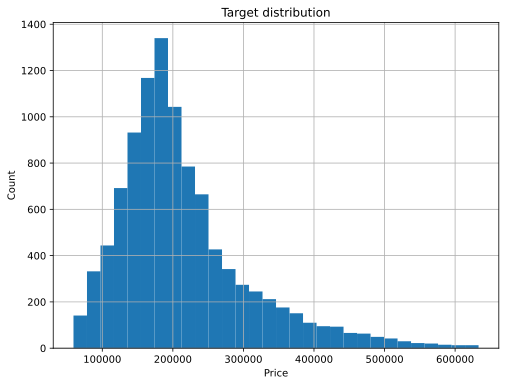

In [8]:
plt.figure(figsize = (8, 6))

df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

По гистограмме видно, что распределение нормальное, выбросы по стоимости отсутствуют.

In [9]:
df_test = pd.read_csv(TEST_DATASET_PATH, sep=',')
df_test.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
5,868,38,3.0,87.139994,53.180419,10.0,4,23.0,2011,0.060753,B,B,15,2787,2,520.0,0,7,B
6,672,62,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A
7,2471,2,2.0,48.172969,29.924204,6.0,4,9.0,1974,0.000000,B,B,33,7425,1,NaN,2,5,B
8,4510,1,1.0,43.153761,21.017596,9.0,10,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B
9,8354,62,2.0,62.593787,59.786844,10.0,1,16.0,1981,0.002212,B,B,39,7614,3,NaN,1,5,A


Есть пропуски данных в жилой площади и показателях, связанных с охраной здоровья. \
Жилую площадь заполнить на основании медианных данных квартир. \
Показатели охраны здоровья - по районам.

In [10]:
df['Id'][df['Square'] < (df['LifeSquare'] + df['KitchenSquare'])].count()

845

В 845 объектах общая площадь меньше суммы жилой площади и площади кухни - выбросы

In [11]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


## 2. Предобработка данных

## 3. Визуализация данных

### Категориальные переменные

В качестве категориальных переменных в датасете присутствуют:
* DistrictId (можем заменить на среднее значение цен квартир в районе
* Ecology_2
* Ecology_3
* Shops_2

В датасете присутствует 4 категориальных переменных, которые необходимо заменить на количественные.\
Замена будет производится в разделе "Генерация новых признаков"

### Заполнение пропусков

In [12]:
df.isna()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [13]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Для заполнения пропусков по жилой площади (LifeSquare) введем коэффициент дополнительного пространства (коридоры, с/у).

In [14]:
condition = (~df['Square'].isna()) & (~df['LifeSquare'].isna()) & (~df['KitchenSquare'].isna())
other_square = (df.loc[condition, 'Square'] \
                     - df.loc[condition, 'LifeSquare'] \
                     - df.loc[condition, 'KitchenSquare']).median()

df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
condition = (df['LifeSquare'].isna()) & \
              (~df['Square'].isna()) & \
              (~df['KitchenSquare'].isna())

df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] - df.loc[condition, 'KitchenSquare'] - other_square

Заполнили жилую площадь медианными значениями по всем остальным объектам.

In [15]:
df['LifeSquare'].isna().sum()

0

#### Заполнение пропусков в столбце Healthcare_1

In [16]:
df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.519470
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

Так как в датасете заполнено только половина значений признака, можно попробовать его выкинуть, \
так как заполнение по медиане не даст точного значения

In [17]:
df.drop(columns='Healthcare_1', inplace=True)

In [18]:
df.isna().sum()

Id                0
DistrictId        0
Rooms             0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Ecology_2         0
Ecology_3         0
Social_1          0
Social_2          0
Social_3          0
Helthcare_2       0
Shops_1           0
Shops_2           0
Price             0
LifeSquare_nan    0
dtype: int64

### Отработка выбросов

In [19]:
df['Id'][df['HouseFloor'] == 0].count()

269

Заполним пропуски значений HouseFloor через медиану

In [20]:
median = df['HouseFloor'].median()
df['HouseFloor'][df['HouseFloor'] == 0] = median

In [21]:
df['Id'][df['Floor'] > df['HouseFloor']].count()

1610

Для строк, где этаж квартиры боьльше этажа дома, поменяем строки местами.

In [22]:
floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
df['HouseFloor_change'] = 0
df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_change'] = df['Floor']
df.loc[df['HouseFloor_change'] != 0, 'Floor'] = df['HouseFloor']
df.loc[df['HouseFloor_change'] != 0, 'HouseFloor'] = df['HouseFloor_change']
df.drop(columns='HouseFloor_change', inplace=True)

Заполним пропуски значений Rooms через медиану

In [23]:
median = df['Rooms'].median()
df['Rooms'][df['Rooms'] == 0] = median

Проверка выбросов по Rooms через гистограмму

<AxesSubplot:>

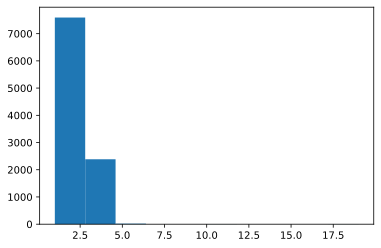

In [24]:
df['Rooms'].hist(grid=False)

Для жилой площади, меньше площади квартиры, заполним суммой входящих в нее площадей (LifeSquare, KitchenSquare, OtherSquare)

In [25]:
df['Id'][df['Square'] < (df['LifeSquare'] + df['KitchenSquare'])].count()

845

In [26]:
condition = df['Square'] < (df['LifeSquare'] + df['KitchenSquare'])
df.loc[condition, 'Square'] = df.loc[condition, 'LifeSquare'] + df.loc[condition, 'KitchenSquare'] + other_square

#### Год постройки дома

In [27]:
df['HouseYear'].describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [28]:
df['HouseYear'][df['HouseYear'].astype(str).str.len() > 4] = df['HouseYear'].astype(str).str[:4].astype(float)

In [29]:
df['HouseYear'].describe()

count    10000.00000
mean      1985.16570
std         35.05515
min       1910.00000
25%       1974.00000
50%       1977.00000
75%       2001.00000
max       4968.00000
Name: HouseYear, dtype: float64

## 4. Генерация новых признаков

#### Dummies

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[['Ecology_2', 'Ecology_3', 'Shops_2']] = df[['Ecology_2', 'Ecology_3', 'Shops_2']].apply(lambda col: le.fit_transform(col))
df[['Ecology_2', 'Ecology_3', 'Shops_2']].head(10)

,Ecology_2,Ecology_3,Shops_2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
5,1,1,1
6,1,1,1
7,1,1,1
8,1,1,1
9,1,1,1


В качестве новых признаков будем использовать среднюю цену квадратного метра в районе\
(в зависимости от количества комнат)

#### DistrictId

In [31]:
district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [32]:
df = df.merge(district_size, on='DistrictId', how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027313,93.659698,10.0,4,10.0,2014,0.075424,...,1,11,3097,0,0,0,1,305018.875000,1,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,30,6207,1,1,0,1,177734.546875,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,33,5261,0,3,1,1,282078.718750,0,652
3,2352,1,1.0,40.409908,28.042292,1.0,10,22.0,1977,0.007122,...,1,1,264,0,0,1,1,168106.000000,1,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,1,33,8667,2,0,6,1,343995.093750,0,89


In [33]:
med_price_per_rooms = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

In [34]:
df = df.merge(med_price_per_rooms, on=['DistrictId', 'Rooms'], how='left')

df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize,MedPriceByDistrict
0,11809,27,3.0,115.027313,93.659698,10.0,4,10.0,2014,0.075424,...,11,3097,0,0,0,1,305018.875000,1,851,213530.781250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,30,6207,1,1,0,1,177734.546875,0,78,146032.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,33,5261,0,3,1,1,282078.718750,0,652,244005.281250
3,2352,1,1.0,40.409908,28.042292,1.0,10,22.0,1977,0.007122,...,1,264,0,0,1,1,168106.000000,1,652,146735.671875
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,33,8667,2,0,6,1,343995.093750,0,89,201584.437500


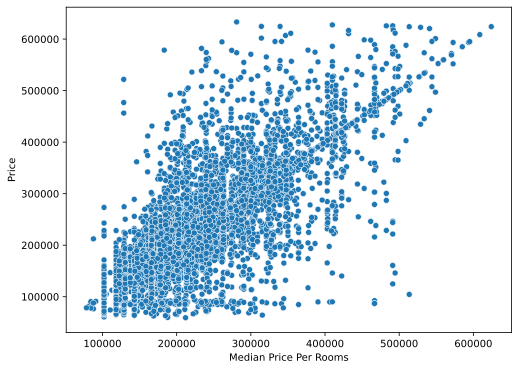

In [35]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x=df['MedPriceByDistrict'], y=df['Price'])
plt.xlabel('Median Price Per Rooms')
plt.ylabel('Price')
plt.show()

Заметна корреляция между показателями MedianPricePerRooms и Price

#### HouseYear

Заменим год постройки дома на его возраст

In [36]:
df['HouseAge'] = 0
df['HouseAge'] = datetime.now().year - df['HouseYear']
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize,MedPriceByDistrict,HouseAge
0,11809,27,3.0,115.027313,93.659698,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.875000,1,851,213530.781250,8
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.546875,0,78,146032.828125,56
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.718750,0,652,244005.281250,34
3,2352,1,1.0,40.409908,28.042292,1.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.000000,1,652,146735.671875,45
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.093750,0,89,201584.437500,50


Сгруппировать дома по возрастам (через каждые 10 лет)

In [37]:
df['age_cat'] = 0
max_age = math.ceil(df['HouseAge'].max() / 10)
bins = np.arange(0, max_age + 1) * 10
df['age_cat'] = pd.cut(df['HouseAge'], bins=bins, labels=False)
df['age_cat'].fillna(-1, inplace=True)

In [38]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize,MedPriceByDistrict,HouseAge,age_cat
0,11809,27,3.0,115.027313,93.659698,10.0,4,10.0,2014,0.075424,...,0,0,0,1,305018.875000,1,851,213530.781250,8,0.0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,1,0,1,177734.546875,0,78,146032.828125,56,5.0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,3,1,1,282078.718750,0,652,244005.281250,34,3.0
3,2352,1,1.0,40.409908,28.042292,1.0,10,22.0,1977,0.007122,...,0,0,1,1,168106.000000,1,652,146735.671875,45,4.0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,2,0,6,1,343995.093750,0,89,201584.437500,50,4.0


In [39]:
df['floor_cat'] = 0
bins = [0, 3, 5, 9, 15, df['Floor'].max()]
df['floor_cat'] = pd.cut(df['Floor'], bins=bins, labels=False)

df['floor_cat'].fillna(-1, inplace=True)

In [40]:
med_price_age = df.groupby(['age_cat', 'floor_cat'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByAge'})
df = df.merge(med_price_age, on=['age_cat', 'floor_cat'], how='left')

df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize,MedPriceByDistrict,HouseAge,age_cat,floor_cat,MedPriceByAge
0,11809,27,3.0,115.027313,93.659698,10.0,4,10.0,2014,0.075424,...,0,1,305018.875000,1,851,213530.781250,8,0.0,1,158607.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,1,177734.546875,0,78,146032.828125,56,5.0,2,200739.437500
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,1,282078.718750,0,652,244005.281250,34,3.0,0,206782.390625
3,2352,1,1.0,40.409908,28.042292,1.0,10,22.0,1977,0.007122,...,1,1,168106.000000,1,652,146735.671875,45,4.0,3,183842.750000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,6,1,343995.093750,0,89,201584.437500,50,4.0,4,176650.437500


## 5. Функции на предобработку данных и генерацию новых признаков

In [41]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.other_square = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.life_square_quantile = X['LifeSquare'].quantile(.975)
        
        condition = (~X['Square'].isna()) & (~X['LifeSquare'].isna()) & (~X['KitchenSquare'].isna())
        self.other_square = (X.loc[condition, 'Square'] \
                             - X.loc[condition, 'LifeSquare'] \
                             - X.loc[condition, 'KitchenSquare']).median()
    
    def transform(self, X):
        """Трансформация данных"""
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X['HouseFloor_change'] = 0
        X.loc[floor_outliers, 'HouseFloor_change'] = X['Floor']
        
        X.loc[X['HouseFloor_change'] != 0, 'Floor'] = X['HouseFloor']
        X.loc[X['HouseFloor_change'] != 0, 'HouseFloor'] = X['HouseFloor_change']
        X.drop(columns='HouseFloor_change', inplace=True)
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - self.other_square
        
        X.loc[X['LifeSquare'] > self.life_square_quantile, 'LifeSquare'] = self.medians['LifeSquare']
        
        # Square
        X['Square_outlier'] = 0
        X.loc[X['Square'] < (X['LifeSquare'] + X['KitchenSquare']), 'Square_outlier'] = 1
        condition = X['Square'] < (X['LifeSquare'] + X['KitchenSquare'])
        
        X.loc[condition, 'Square'] = X.loc[condition, 'LifeSquare'] + X.loc[condition, 'KitchenSquare'] + self.other_square
        
        # Прочие пропуски
        X.fillna(self.medians, inplace=True)
        
        return X

In [42]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.med_price_by_district = None
        self.med_price_by_floor_age = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            df['HouseAge'] = datetime.now().year - df['HouseYear']
            self.house_year_max = df['HouseAge'].max()
            
            df = self.age_to_cat(df)
            df = self.floor_to_cat(df)
            df['Price'] = y.values

            self.med_price_by_floor_age = df.groupby(['AgeCat', 'FloorCat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorAge'})
            self.med_price_by_floor_age_median = self.med_price_by_floor_age['MedPriceByFloorAge'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X[['Ecology_2', 'Ecology_3', 'Shops_2']] = X[['Ecology_2', 'Ecology_3', 'Shops_2']].apply(lambda col: le.fit_transform(col))
        
        # DistrictId, DistrictSize
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        X['HouseAge'] = 0
        X['HouseAge'] = datetime.now().year - X['HouseYear']
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.age_to_cat(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_age is not None:
            X = X.merge(self.med_price_by_floor_age, on=['AgeCat', 'FloorCat'], how='left')
            X['MedPriceByFloorAge'].fillna(self.med_price_by_floor_age_median, inplace=True)
        
        return X
    
    def age_to_cat(self, X):
        max_age = math.ceil(self.house_year_max / 10)
        bins = np.arange(0, max_age + 1) * 10
        X['AgeCat'] = pd.cut(X['HouseAge'], bins=bins, labels=False)
        X['AgeCat'].fillna(-1, inplace=True)
        return X
    def floor_to_cat(self, X):        
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['FloorCat'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['FloorCat'].fillna(-1, inplace=True)
        return X

## 6. Отбор используемых признаков

In [43]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'DistrictSize',
 'MedPriceByDistrict',
 'HouseAge',
 'age_cat',
 'floor_cat',
 'MedPriceByAge']

In [44]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'Square_outlier', 'LifeSquare_nan', 'DistrictSize',
                    'IsDistrictLarge', 'AgeCat', 'FloorCat', 'MedPriceByDistrict', 'MedPriceByFloorAge']

target_name = 'Price'

## 7. Разбиение на train, valid, test, заполнение датасетов

In [45]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
X['Id'] = X['Id'].astype(str)

y = train_df[target_name]

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [47]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [48]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [49]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,LifeSquare_nan,Square_outlier,DistrictSize,IsDistrictLarge,HouseAge,FloorCat,AgeCat,MedPriceByDistrict,MedPriceByFloorAge
0,11585,23,1.0,43.380798,26.987134,5.0,18,25.0,1977,0.075779,...,0,1,0,372,1,45,4,4.0,104300.893609,175741.008933
1,2917,30,3.0,83.596365,67.202701,5.0,3,16.0,1977,0.000078,...,0,1,0,148,1,45,0,4.0,197241.123890,177297.205093
2,9635,47,2.0,53.610583,31.289235,8.0,12,14.0,1979,0.298205,...,0,0,0,64,0,43,3,4.0,228796.542555,182050.357532
3,8748,3,2.0,51.877576,30.075022,6.0,3,9.0,1974,0.265089,...,0,0,0,44,0,48,0,4.0,184712.770172,177297.205093
4,5704,62,1.0,53.810968,37.417304,5.0,4,13.0,1977,0.072158,...,0,1,0,164,1,45,1,4.0,131107.271962,180750.471749


In [50]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [51]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## 7. Построение модели

### Функция для построения графиков и подсчета качества модели

In [52]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """Оценка качества модели и график preds vs true"""
   
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### RandomForestRegressor (с подбором параметров)

Train R2:	0.959
Test R2:	0.72


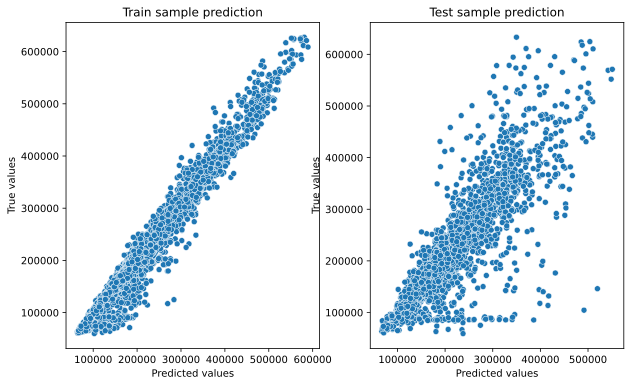

In [53]:
rfr_b_model = RandomForestRegressor(max_depth=17, max_features=7, n_estimators=100, random_state=42)
rfr_b_model.fit(X_train, y_train)
y_train_preds = rfr_b_model.predict(X_train)
y_valid_preds = rfr_b_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

## 8. Оценка модели

#### Кросс-валидация

In [54]:
cv_score = cross_val_score(rfr_b_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.77582469, 0.7436232 , 0.75922475])

In [55]:
cv_score.mean()

0.7595575471407546

#### Важность признаков

In [56]:
feature_importances = pd.DataFrame(zip(X_train.columns, rfr_b_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
25,MedPriceByDistrict,3.119504e-01
1,Square,1.583781e-01
0,Rooms,8.751927e-02
2,LifeSquare,6.922672e-02
21,DistrictSize,6.335172e-02
11,Social_2,3.628318e-02
10,Social_1,2.886358e-02
26,MedPriceByFloorAge,2.878980e-02
12,Social_3,2.711749e-02
5,HouseFloor,2.651652e-02


## 9. Прогнозирование на тестовом датасете

In [57]:
test_df.shape

(5000, 27)

In [58]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,HouseFloor_outlier,HouseYear_outlier,Square_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,AgeCat,FloorCat,MedPriceByDistrict,MedPriceByFloorAge
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,0,0,76.0,0,5.0,1.0,171145.169069,184096.539634
1,1.0,63.961796,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,1,0,164.0,1,0.0,2.0,131107.271962,180042.914720
2,2.0,59.463678,39.070015,9.0,19,19.0,1977,0.211401,1,1,...,0,0,0,1,580.0,1,4.0,4.0,166353.734353,175741.008933
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,0,372.0,1,5.0,0.0,172778.615365,177855.183166
4,1.0,53.837056,37.443392,5.0,8,17.0,1977,0.309479,1,1,...,0,0,0,1,65.0,0,4.0,2.0,164116.183543,183431.410161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5,6.0,1962,0.069660,1,1,...,1,0,0,0,56.0,0,5.0,1.0,183575.963167,184096.539634
4996,3.0,93.698122,32.679351,10.0,21,27.0,2018,0.060753,1,1,...,0,0,0,0,26.0,0,0.0,4.0,425037.641820,191797.237608
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,0,0,0,0,54.0,0,5.0,0.0,156266.487610,177855.183166
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,0,0,0,0,40.0,0,5.0,2.0,185704.766694,204485.290575


In [59]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [60]:
predictions = rfr_b_model.predict(test_df)
predictions

array([154248.84862354, 128131.63128209, 141768.96722785, ...,
       146165.82603528, 192586.11262239, 224507.70921796])

In [61]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,154248.848624
1,5925,128131.631282
2,960,141768.967228
3,3848,150201.585427
4,746,180788.273664


In [62]:
submit.to_csv('./submits.csv', index=False)